In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm
from matplotlib.patches import Rectangle
from amftrack.transport.align_video_network import identify_nodes, selected_rectangle
from IPython.display import clear_output
import re
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.development.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox,
    analysis_run,
)
from amftrack.pipeline.development.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
import sys
import os
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
import scipy
import matplotlib as mpl
from pathlib import Path
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
import dropbox
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.util.dbx import upload

mpl.rcParams["figure.dpi"] = 60

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-09-05 11:41:48.263915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 11:41:48.393211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-09-05 11:41:48.393249: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
plates = ["532_20220104"]

In [3]:
# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/1228 [00:00<?, ?it/s]

In [21]:
all_folders["unique_id"].unique()

array(['532_20220104', '441_20230807', '764_20221219', '449_20230807',
       '720_20221110', '762_20221213', '414_20230814', '763_20230109',
       '713_20221108', '737_20221025', '734_20221019', '480_20221205',
       '545_20220115'], dtype=object)

In [4]:
folders = all_folders.loc[all_folders["unique_id"] == plates[0]]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]

In [28]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,fungalC,unique_id,datetime
0,/projects/0/einf914/data/20230119_1355_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"19.01.2023, 13:55:",20230119_1355_Plate04,NaN,532_20220104,2023-01-19 13:55:00
5,/projects/0/einf914/data/20230124_1000_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"24.01.2023, 10:00:",20230124_1000_Plate04,NaN,532_20220104,2023-01-24 10:00:00
10,/projects/0/einf914/data/20230114_1955_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"14.01.2023, 19:55:",20230114_1955_Plate04,NaN,532_20220104,2023-01-14 19:55:00
16,/projects/0/einf914/data/20230116_1355_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"16.01.2023, 13:55:",20230116_1355_Plate04,NaN,532_20220104,2023-01-16 13:55:00
21,/projects/0/einf914/data/20230121_1600_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"21.01.2023, 16:00:",20230121_1600_Plate04,NaN,532_20220104,2023-01-21 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,/projects/0/einf914/data/20230120_1359_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"20.01.2023, 13:59:",20230120_1359_Plate04,NaN,532_20220104,2023-01-20 13:59:00
890,/projects/0/einf914/data/20230120_2200_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"20.01.2023, 22:00:",20230120_2200_Plate04,NaN,532_20220104,2023-01-20 22:00:00
891,/projects/0/einf914/data/20230106_1155_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"06.01.2023, 11:55:",20230106_1155_Plate04,NaN,532_20220104,2023-01-06 11:55:00
893,/projects/0/einf914/data/20230105_0839_Plate04,532,4,'CarrotEN','C2','001P100N100C','Y','-',20220104,25,...,False,True,True,True,True,"05.01.2023, 08:39:",20230105_0839_Plate04,NaN,532_20220104,2023-01-05 08:39:00


In [20]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 60
exp.load(folders.iloc[i : i + 2], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-01-09 14:15:00
2023-01-09 15:55:00


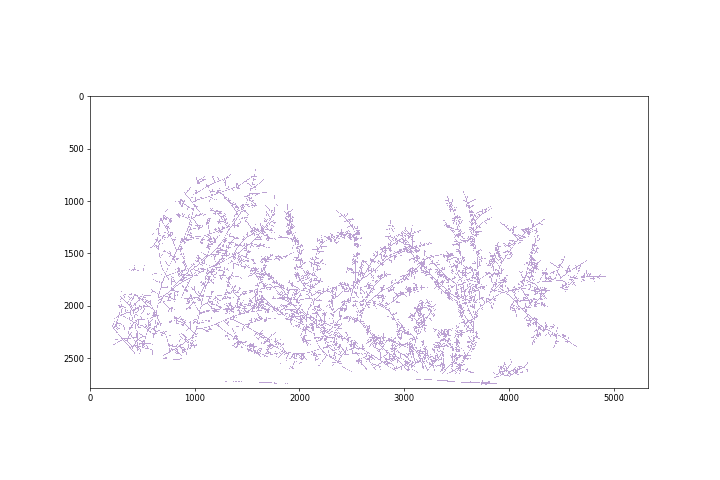

In [21]:
dpi = 400

vmax = 1
vmin = 0
downsizing = 10
fig, ax = plot_edge_color_value(
    exp,
    0,
    lambda edge: 1,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    show_background=False,
    dilation=5,
    figsize=(12, 8),
    downsizing=downsizing,
)

In [22]:
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm  # for Jupyter notebook or IPython

positions = exp.positions[0]


def angle_between(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return np.arccos(np.clip(dot_product / norm_product, -1.0, 1.0))


def relation(v, e1, e2, EExtract, E, positions):
    v_i = E[e1][0] if E[e1][1] == v else E[e1][1]
    v_j = E[e2][0] if E[e2][1] == v else E[e2][1]

    vec_i = np.array(positions[v_i]) - np.array(positions[v])
    vec_j = np.array(positions[v_j]) - np.array(positions[v])

    theta = np.pi / 4  # Adjust this value based on your requirements

    # Check the first condition
    if abs(angle_between(vec_i, vec_j) - np.pi) > theta:
        return False

    # Check the second condition
    for e in EExtract:
        if e != e1 and e != e2:
            v_k = E[e][0] if E[e][1] == v else E[e][1]
            vec_k = np.array(positions[v_k]) - np.array(positions[v])

            if abs(angle_between(vec_k, vec_i) - np.pi) < abs(
                angle_between(vec_i, vec_j) - np.pi
            ) or abs(angle_between(vec_k, vec_j) - np.pi) < abs(
                angle_between(vec_i, vec_j) - np.pi
            ):
                return False

    return True


def hypergraph_from_graph(G, positions):
    V = list(G.nodes())
    E = list(G.edges())
    e = len(E)
    v = len(V)

    H = [0] * e
    Cor = [[0] * 10 for _ in range(e)]

    # STEP 1
    for i in tqdm(V, desc="Processing vertices"):
        EExtract = [edge_idx for edge_idx, edge in enumerate(E) if i in edge]
        for j in range(len(EExtract)):
            for k in range(j + 1, len(EExtract)):
                e1 = EExtract[j]
                e2 = EExtract[k]
                if relation(i, e1, e2, EExtract, E, positions):
                    Cor[e1][Cor[e1].index(0)] = e2
                    Cor[e2][Cor[e2].index(0)] = e1

    # STEP 2
    CurrentMark = 1
    for i in tqdm(range(e), desc="Processing stack"):
        if H[i] == 0:
            stack = [i]
            visited = set()  # To keep track of edges that have been added to the stack
            while stack:
                current = stack.pop()
                H[current] = CurrentMark
                # Only add edges to the stack that haven't been assigned to a hyperedge and aren't already on the stack
                related_edges = [
                    cor
                    for cor in Cor[current]
                    if cor != 0 and H[cor] == 0 and cor not in visited
                ]
                stack.extend(related_edges)
                visited.update(related_edges)
            CurrentMark += 1
    H = {edge: H[i] for i, edge in enumerate(E)}
    return H

In [23]:
# Example usage
G = exp.nx_graph[0]
E = list(G.edges())

# Add edges to G...
H = hypergraph_from_graph(G, positions)
H = {Edge(Node(edge[0], exp), Node(edge[1], exp), exp): H[edge] for edge in H.keys()}

Processing vertices:   0%|          | 0/22863 [00:00<?, ?it/s]

Processing stack:   0%|          | 0/13657 [00:00<?, ?it/s]

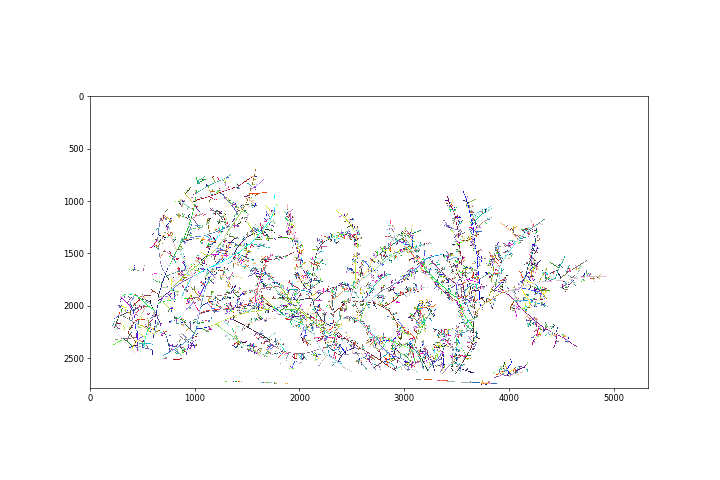

In [24]:
plt.close("all")
dpi = 400

vmax = 5
vmin = 0
downsizing = 10
edges = get_all_edges(exp, 0)

ax = plot_full_hyper(
    exp,
    0,
    edges=edges,
    color_seed=lambda edge: H[edge] % 255,
    dilation=5,
    figsize=(12, 8),
    downsizing=downsizing,
)

In [ ]:
from amftrack.pipeline.functions.post_processing.util import *

diclength = {value: 0 for value in H.values()}
for edge in H.keys():
    diclength[H[edge]] += measure_length_um_edge(edges[0], 0)

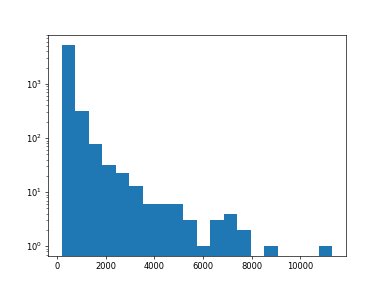

In [37]:
fig, ax = plt.subplots()
ax.hist(diclength.values(), 20)
ax.set_yscale("log")
# ax.set_xscale('log')

In [40]:
list(data)

[179.5879258151918,
 1077.5275548911507,
 179.5879258151918,
 1436.7034065215341,
 179.5879258151918,
 538.7637774455754,
 359.1758516303836,
 179.5879258151918,
 179.5879258151918,
 359.1758516303836,
 538.7637774455754,
 179.5879258151918,
 718.3517032607672,
 179.5879258151918,
 179.5879258151918,
 718.3517032607672,
 179.5879258151918,
 179.5879258151918,
 897.9396290759589,
 179.5879258151918,
 179.5879258151918,
 179.5879258151918,
 179.5879258151918,
 359.1758516303836,
 179.5879258151918,
 179.5879258151918,
 359.1758516303836,
 179.5879258151918,
 179.5879258151918,
 179.5879258151918,
 359.1758516303836,
 2334.643035597493,
 359.1758516303836,
 179.5879258151918,
 359.1758516303836,
 179.5879258151918,
 179.5879258151918,
 538.7637774455754,
 179.5879258151918,
 718.3517032607672,
 897.9396290759589,
 718.3517032607672,
 179.5879258151918,
 359.1758516303836,
 359.1758516303836,
 179.5879258151918,
 179.5879258151918,
 538.7637774455754,
 179.5879258151918,
 179.5879258151918

Estimated b: 1.8116271209157317


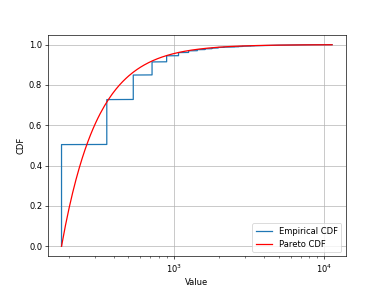

In [45]:
data = diclength.values()
data = list(data)
fig, ax = plt.subplots()

# Empirical CDF
data_sorted = np.sort(data)
p = 1.0 * np.arange(len(data)) / (len(data) - 1)

ax.plot(data_sorted, p, label="Empirical CDF")
ax.set_xlabel("Value")
ax.set_ylabel("CDF")
ax.grid(True)
from scipy.stats import pareto

# Estimating b using the mean method
xm = np.min(data)
b = len(data) / (np.sum(np.log(data / xm)))

print(f"Estimated b: {b}")
x = np.linspace(np.min(data), np.max(data), 1000)
cdf_pareto = pareto.cdf(x, b, scale=xm)

ax.plot(x, cdf_pareto, "r", label="Pareto CDF")
ax.legend()
ax.set_xscale("log")

In [18]:
from amftrack.pipeline.functions.image_processing.experiment_util import *


def plot_full_hyper(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    color_seed: Callable = lambda edge: (edge.begin.label + edge.end.label),
    points: List[coord_int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[color_seed(edge) for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )

    # 3/ Fusing layers
    fig = plt.figure(
        figsize=figsize
    )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
    ax = fig.add_subplot(111)
    ax.imshow(skel_im, alpha=1, interpolation="none")

    # 3/ Plotting the Nodes
    size = node_size
    for node in nodes:
        c = f(list(node.pos(t)))
        color = make_random_color(node.label)[:3]
        reciprocal_color = 255 - color
        color = tuple(color / 255)
        reciprocal_color = tuple(reciprocal_color / 255)
        bbox_props = dict(boxstyle="circle", fc=color, edgecolor="none")
        if is_in_bounding_box(c, new_region):
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                bbox=bbox_props,
                font=fpath,
                fontdict={"color": reciprocal_color},
                size=size,
                # alpha = 0.5
            )
    # 4/ Plotting coordinates
    points = [f(c) for c in points]
    for i, c in enumerate(points):
        if is_in_bounding_box(c, new_region):
            plt.plot(c[1], c[0], marker="x", color="red", markersize=10, alpha=0.5)
            if with_point_label:
                plt.text(c[1], c[0], f"{i}")

    # 5/ Plotting segments
    segments = [[f(segment[0]), f(segment[1])] for segment in segments]
    for s in segments:
        plt.plot(
            [s[0][1], s[1][1]],  # x1, x2
            [s[0][0], s[1][0]],  # y1, y2
            color="white",
            linewidth=2,
        )

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    return ax